In [1]:
import pandas as pd
chlo = "chloride.csv"
sofa = "sofa_pan.csv"
aki = "aki_final.csv"

sofa = pd.read_csv(sofa)
chl = pd.read_csv(chlo)
aki = pd.read_csv(aki)

In [2]:
df = pd.read_csv('newaki.csv')
df

,icustay_id,new_aki
0,200001,1
1,200003,1
2,200006,0
3,200007,0
4,200009,0
5,200010,0
6,200011,0
7,200012,0
8,200014,0
9,200016,0


In [3]:
df['new_aki'].value_counts()

0    42702
1    10117
Name: new_aki, dtype: int64

In [4]:
sofadf = sofa[['icustay_id','day','sofa']]
sofadf = sofadf[sofadf['day']==1]
sofadf.head()

,icustay_id,day,sofa
0,211552,1.0,7
6,294638,1.0,2
8,228232,1.0,4
12,220597,1.0,5
18,229441,1.0,2


In [5]:
chldf = chl[['icustay_id','icu_day','chloride_max']]
chldf = chldf[chldf['icu_day']<=3]
idx = chldf.groupby(['icustay_id'])['chloride_max'].transform(max) == chldf['chloride_max']
chldf = chldf[idx][['icustay_id','chloride_max']]
chldf.head()

,icustay_id,chloride_max
0,211552,114.0
6,294638,108.0
9,228232,102.0
13,220597,103.0
14,220597,103.0


In [6]:
df1 = pd.merge(sofadf, chldf, on='icustay_id')
df1.head()

,icustay_id,day,sofa,chloride_max
0,211552,1.0,7,114.0
1,294638,1.0,2,108.0
2,228232,1.0,4,102.0
3,220597,1.0,5,103.0
4,220597,1.0,5,103.0


In [7]:
df2 = pd.merge(df1, df, on='icustay_id')
df2.head()

,icustay_id,day,sofa,chloride_max,new_aki
0,211552,1.0,7,114.0,0
1,294638,1.0,2,108.0,0
2,228232,1.0,4,102.0,1
3,220597,1.0,5,103.0,0
4,220597,1.0,5,103.0,0


In [8]:
from scipy.stats import ttest_ind

aki0 = df2[df2['new_aki']== 0]
aki1 = df2[df2['new_aki']== 1]

ttest_ind(aki0['chloride_max'], aki1['chloride_max'])

Ttest_indResult(statistic=-8.314758253972592, pvalue=9.395017992447008e-17)

In [9]:
aki1['chloride_max'].mean(),aki1['chloride_max'].std()

(107.74556865405818, 6.382298369862417)

In [10]:
aki0['chloride_max'].mean(),aki0['chloride_max'].std()

(107.22375850264527, 5.980126486221921)

In [11]:
df2['new_aki'].value_counts()

0    44986
1    11791
Name: new_aki, dtype: int64

In [12]:
import statsmodels.api as sm

def p_logit(X,y,form='univariate',confounder=None):
    if form=='multivariate':
        logit = sm.Logit(y, pd.concat([X,confounder],axis=1))
        result = logit.fit()
        return result.pvalues[X.columns]
    else:
        pv=pd.Series()
        coef=pd.Series()
        for c in X.columns:
            logit = sm.Logit(y, pd.concat([X[c],confounder],axis=1))
            result = logit.fit()
            pv[c]=result.pvalues[c]
            coef[c]=result.params[c]

    return pv, coef

/Users/panyiheng/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [13]:
X1 = df2[['sofa']]
y1 = df2[['new_aki']]

pv, coef = p_logit(X1, y1)
pv, coef

Optimization terminated successfully.
         Current function value: 0.622855
         Iterations 5


(sofa    0.0
 dtype: float64, sofa   -0.171291
 dtype: float64)

In [14]:
X2 = df2[['chloride_max']]
y2 = df2[['new_aki']]

pv, coef = p_logit(X2, y2)
pv, coef

Optimization terminated successfully.
         Current function value: 0.512392
         Iterations 5


(chloride_max    0.0
 dtype: float64, chloride_max   -0.012406
 dtype: float64)

In [15]:
import statsmodels.api as sm

X = df2[['sofa', 'chloride_max']]
y = df2[['new_aki']]

logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.492923
         Iterations 5
                         Results: Logit
Model:              Logit            No. Iterations:   5.0000    
Dependent Variable: new_aki          Pseudo R-squared: 0.035     
Date:               2018-12-16 21:08 AIC:              55977.3504
No. Observations:   56777            BIC:              55995.2441
Df Model:           1                Log-Likelihood:   -27987.   
Df Residuals:       56775            LL-Null:          -29005.   
Converged:          1.0000           Scale:            1.0000    
-----------------------------------------------------------------
                 Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------
sofa             0.1539   0.0033   46.8402 0.0000  0.1475  0.1604
chloride_max    -0.0185   0.0002 -107.9963 0.0000 -0.0189 -0.0182



In [16]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

/Users/panyiheng/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/panyiheng/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [17]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.5f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.79200


In [18]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[13411    80]
 [ 3463    80]]


In [19]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.99      0.88     13491
           1       0.50      0.02      0.04      3543

   micro avg       0.79      0.79      0.79     17034
   macro avg       0.65      0.51      0.46     17034
weighted avg       0.73      0.79      0.71     17034



In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [21]:
import pandas
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [22]:
validation_size = 0.20
seed = 7
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X, y
                                                                                , test_size=validation_size, random_state=seed)

In [23]:
# Test options and evaluation metric
seed = 7
scoring = 'accuracy'

In [24]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, random_state=seed)
	cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

/Users/panyiheng/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/panyiheng/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/panyiheng/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/panyiheng/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/pan

LR: 0.790537 (0.003387)


/Users/panyiheng/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/panyiheng/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/panyiheng/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/panyiheng/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

LDA: 0.790185 (0.003024)


/Users/panyiheng/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/panyiheng/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/panyiheng/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/panyiheng/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.

KNN: 0.758504 (0.009948)
CART: 0.791352 (0.003289)


/Users/panyiheng/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/panyiheng/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/panyiheng/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/panyiheng/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

NB: 0.786156 (0.002190)


/Users/panyiheng/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/panyiheng/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/panyiheng/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/panyiheng/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will 

KeyboardInterrupt: 

In [ ]:
# Make predictions on validation dataset
svm = SVC()
svm.fit(X_train, Y_train)
predictions = svm.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))


In [25]:
clf = LogisticRegression().fit(X_train, Y_train)

/Users/panyiheng/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/panyiheng/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [33]:
import seaborn as sns

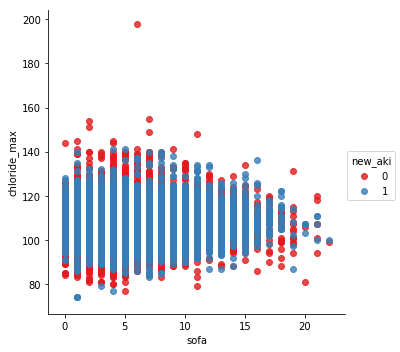

In [35]:
sns.lmplot(
    data=df2,
    x='sofa',
    y='chloride_max',
    hue='new_aki',
    fit_reg=False,
    palette='Set1'
).set_axis_labels('sofa', 'chloride_max');

In [40]:
coef = logreg.coef_[0]

In [38]:
coef

array([0.15253523, 0.00367825])

In [45]:
df2

,icustay_id,day,sofa,chloride_max,new_aki
0,211552,1.0,7,114.0,0
1,294638,1.0,2,108.0,0
2,228232,1.0,4,102.0,1
3,220597,1.0,5,103.0,0
4,220597,1.0,5,103.0,0
5,220597,1.0,5,103.0,0
6,229441,1.0,2,106.0,0
7,232669,1.0,3,113.0,0
8,263738,1.0,1,116.0,0
9,257980,1.0,2,113.0,0
